In [1]:

import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

2024-04-03 19:51:28.600412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-04-03 19:51:32.880276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


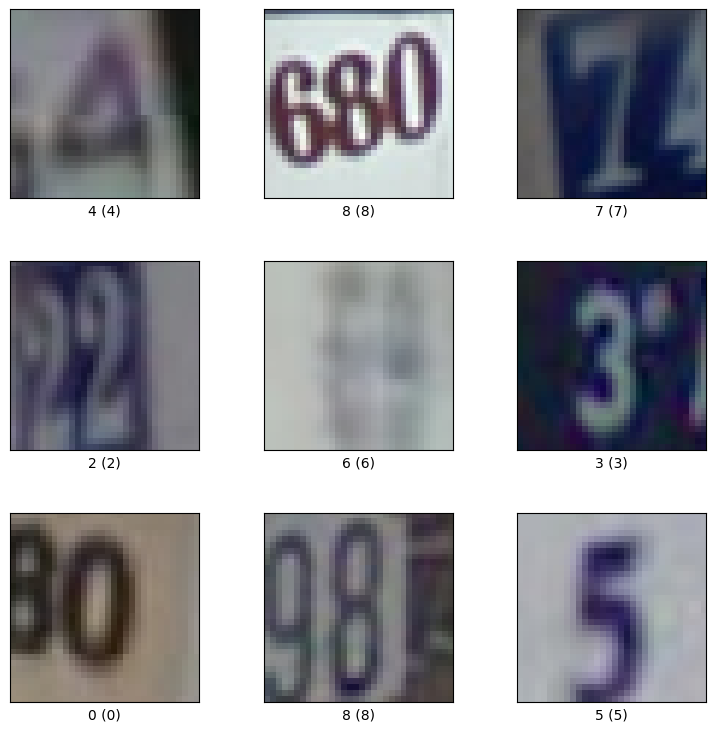

In [2]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

In [3]:
def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

In [4]:
batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 


# Qkeras

In [5]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 fused_convbn_0 (QConv2DBatc  (None, 30, 30, 16)       513       
 hnorm)                                                          
                                                                 
 conv_act_0 (QActivation)    (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 16)        0         
                                                                 
 fused_convbn_1 (QConv2DBatc  (None, 13, 13, 16)       2385      
 hnorm)         

In [6]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)


Number of training steps per epoch is 64


In [8]:
train = False

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

In [9]:
# predict_baseline = model_pruned.predict(X_test)
# test_score_baseline = model_pruned.evaluate(X_test, Y_test)

predict_qkeras = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)

print('QKeras 6-bit accuracy = {}'.format(test_score_qkeras[1]))

814/814 [==============================] - 8s 9ms/step - loss: 0.5377 - accuracy: 0.8557
QKeras 6-bit accuracy = 0.855677604675293


Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_2: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


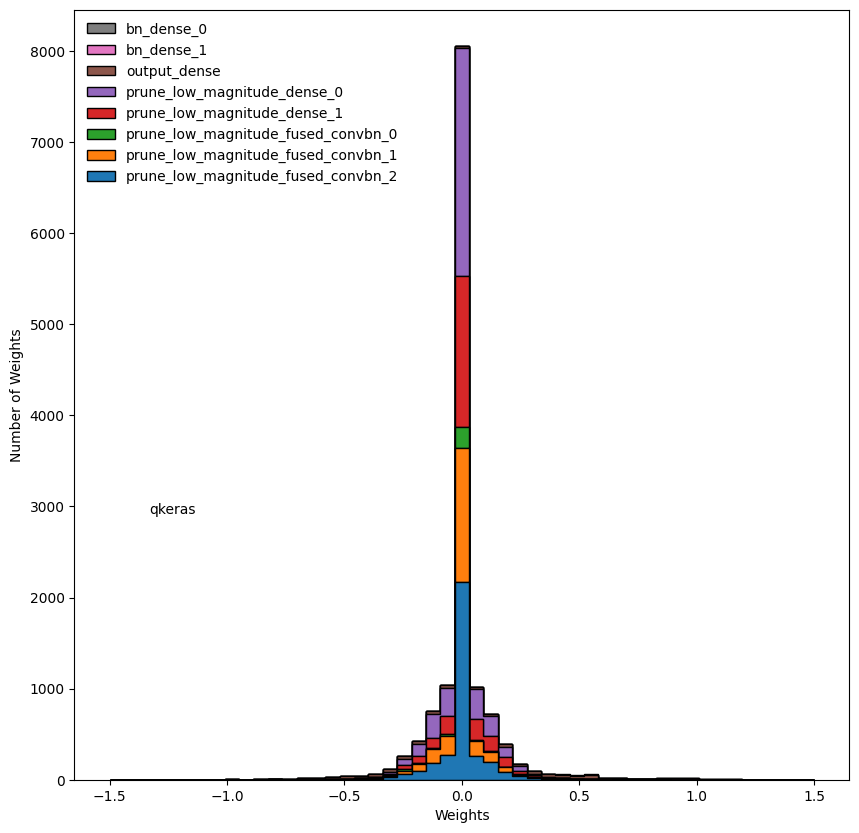

In [10]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


# doWeights(model_pruned)
doWeights(qmodel_pruned)

# HLS4ML

In [11]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

# model = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)
# model = strip_pruning(model)

qmodel = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)
qmodel = strip_pruning(qmodel)

In [12]:

import hls4ml
import plotting

# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 128
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = qmodel
cfg_q['OutputDir'] = 'quantized_pruned_cnn/'
cfg_q['XilinxPart'] = 'xczu5ev-sfvc784-2LV-e'

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Done


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

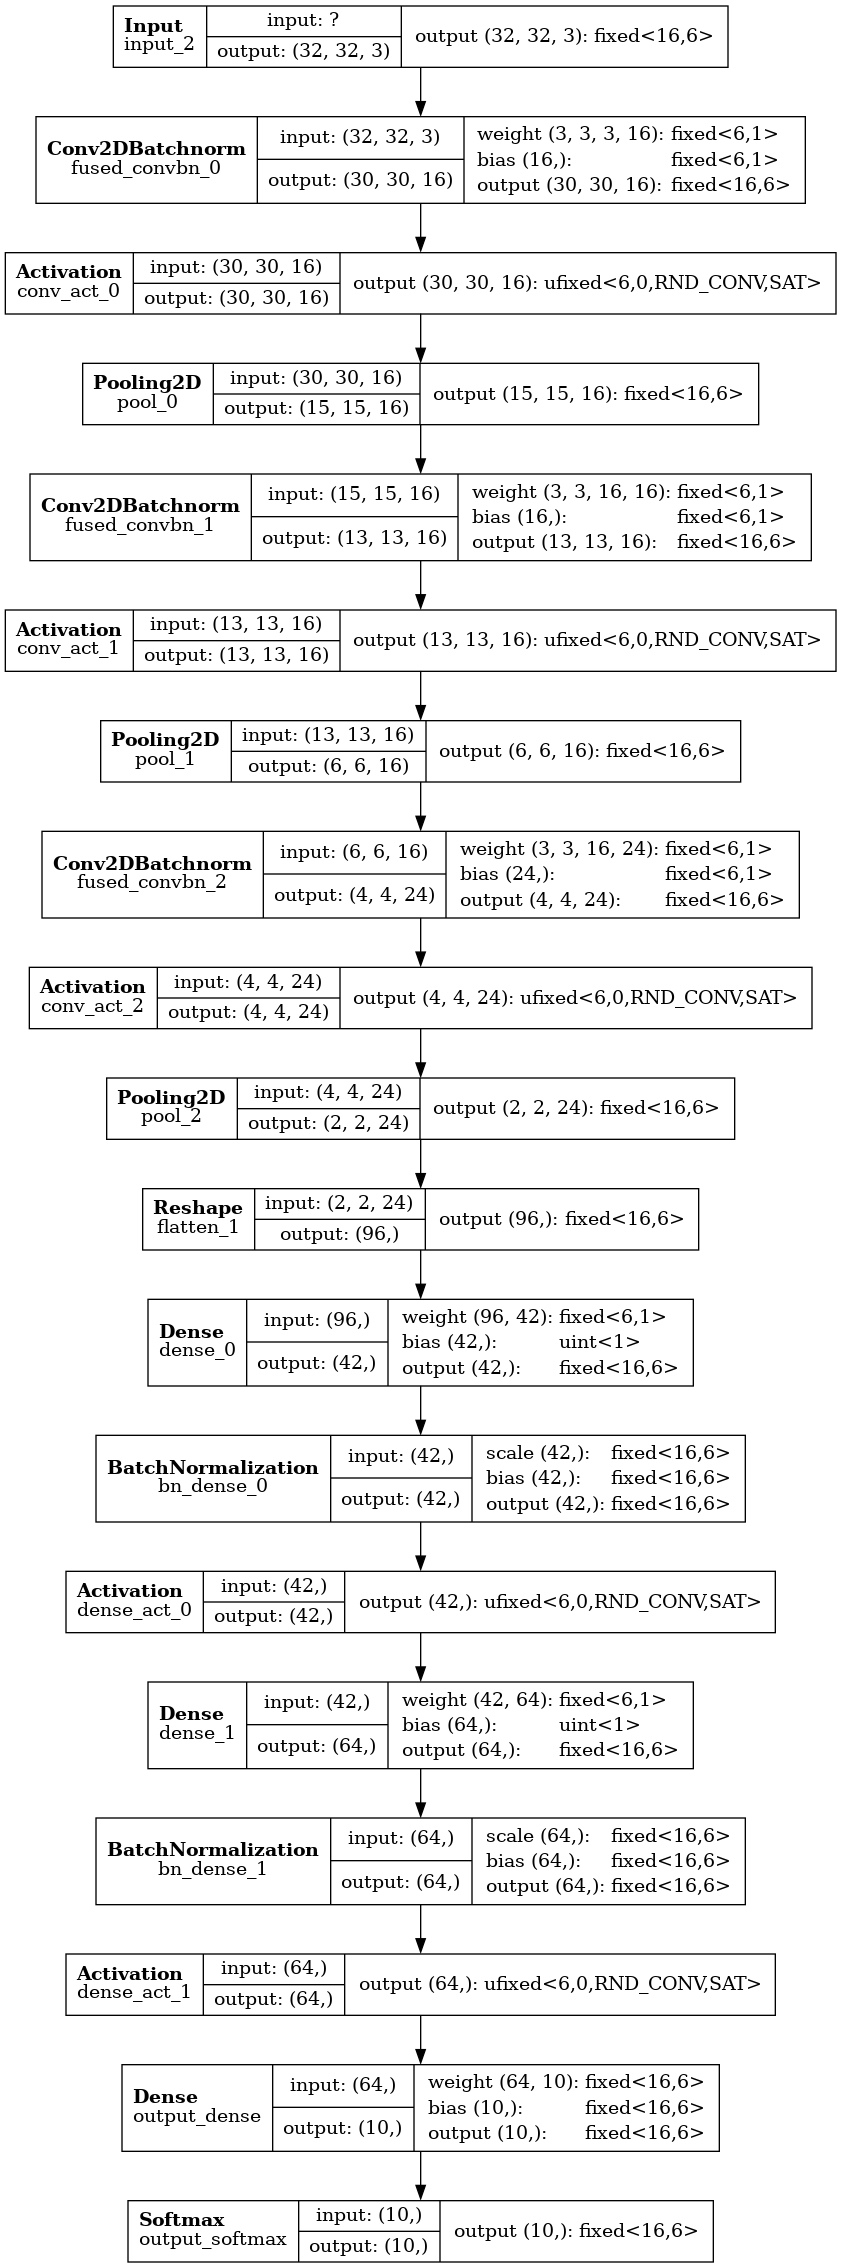

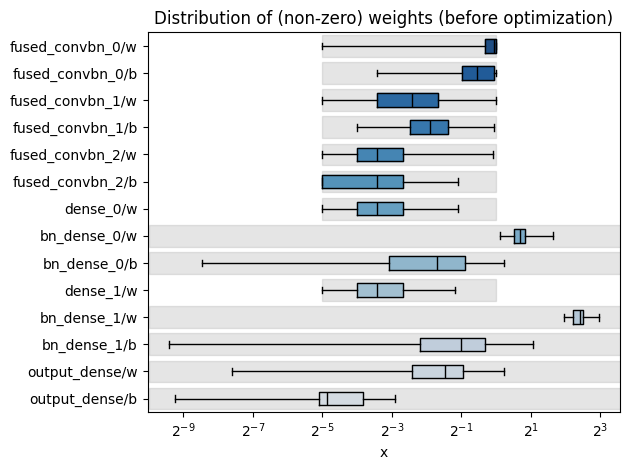

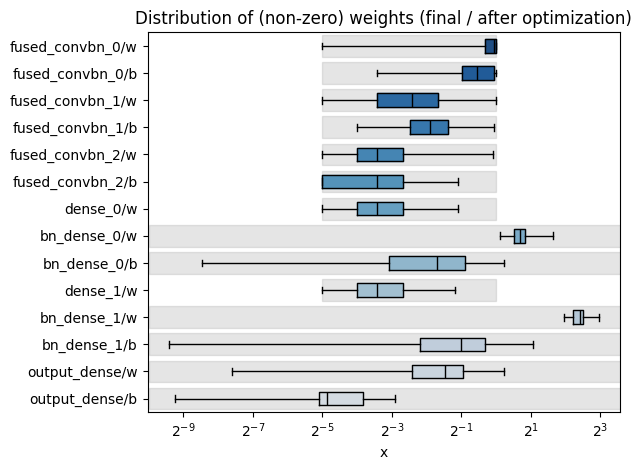

In [13]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [14]:
X_test_reduced = X_test[:3000]
Y_test_reduced = Y_test[:3000]

In [15]:
y_predict_q = qmodel.predict(X_test_reduced)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_reduced))

94/94 [==============================] - 1s 9ms/step


In [16]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

hls_model_q.build(csim=False, synth=True, vsynth=True, cosim = False, bitfile = True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Wed Apr 03 19:54:51 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
I

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 42u>, relu_config18>' (firmware/nnet_utils/nnet_activation_stream.h:52).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 42u>, relu_config18>' (firmware/nnet_utils/nnet_activation_stream.h:51).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>::operator[]' into 'nnet::normalize<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>, config17>' (firmware/nnet_utils/nnet_batchnorm_stream.h:4

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:01:10 ; elapsed = 00:01:25 . Memory (MB): peak = 965.348 ; gain = 532.145 ; free physical = 14694 ; free virtual = 34948
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config25>' (firmware/nnet_utils/nnet_activation_stream.h:193:47).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 64u>, relu_config22>' (firmware/nnet_utils/nnet_activation_stream.h:41:31).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 42u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 42u>, relu_config18>' (firmware/nnet_utils/nnet_activation_stream.h:41:31).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:41) in function 'nn

INFO: [HLS 200-489] Unrolling loop 'SoftmaxArrayPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:201) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config25>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-2' (firmware/nnet_utils/nnet_activation_stream.h:213) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config25>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Loop-3' (firmware/nnet_utils/nnet_activation_stream.h:222) in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, softmax_config25>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'SoftmaxInvPack

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stre

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:37) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config15>' completely with a factor of 96.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config15>' completely with a factor of 42.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config15>' completely with a factor of 42.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (firmware/nnet_utils/nnet_conv_stream.h:303) in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:37) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (

INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.4' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.8' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool_window.V' (firmware/nnet_utils/nnet_pooling_stream.h:178) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'kernel_data.V.4'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.3' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.9' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool_window.V' (firmware/nnet_utils/nnet_pooling_stream.h:178) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning arra

INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.3'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.2'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.1'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<1

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[0].V' to 'b10.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[1].V' to 'b10.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[17].V' to 'b10.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_s

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[9].V' to 'b6.V.9'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[10].V' to 'b6.V.10'

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[12].V' to 'b2.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting '

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/myproject_axi.cpp:32:90) to (firmware/myproject_axi.cpp:31:49) in function 'Loop_2_proc'... converting 10 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/myproject_axi.cpp:22:25) to (firmware/myproject_axi.cpp:20:41) in function 'Loop_1_proc622'... converting 10 basic blocks.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 4, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0>, 10, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)0, (ap_o_mode)0, 0> > >' into 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 01:28:28 ; elapsed = 01:29:45 . Memory (MB): peak = 21093.387 ; gain = 20660.184 ; free physical = 7892 ; free virtual = 23603
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...


INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc622' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 5386.82 seconds; current allocated memory: 932.836 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.65 seconds; current allocated memory: 933.361 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' 
INFO: [HLS 200-10] ------------------------------------

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.88 seconds; current allocated memory: 941.395 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.29 seconds; current allocated memory: 942.710 MB.
INFO: [BIND 205-100] Starting micro-architecture generati

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.82 seconds; current allocated memory: 993.363 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 3.68 seconds; current allocated memory: 995.550 MB.
INFO: [BIND 205-100] Starting micro-architecture generati

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 2.09 seconds; current allocated memory: 1.028 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 4.56 seconds; current allocated memory: 1.031 GB.
INFO: [BIND 205-100] Starting micro-architecture generation 

INFO: [SCHED 204-61] Pipelining function 'dense_wrapper<ap_ufixed<6, 0, 4, 0, 0>, ap_fixed<16, 6, 5, 3, 0>, config19>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 128, Final II = 6, Depth = 6.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 14.62 seconds; current allocated memory: 1.114 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 54.52 seconds; current allocated memory: 1.127 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_array_ap_ufixed_42u_array_ap_fixed_16_6_5_3_0_64u_config19_s' 
INFO: [HLS 200-10] ----------------------------------------------------

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 4.59 seconds; current allocated memory: 1.189 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 4.7 seconds; current allocated memory: 1.189 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.88 seconds; current allocated memory: 1.190 GB.
INFO: [HLS 200-10] ------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 9.67 seconds; current allocated memory: 1.285 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_16u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 2.5 seconds; current allocated memory: 1.288 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
I

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_16_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 6.16 seconds; current allocated memory: 1.302 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_V_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_VxdS' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_V_1520_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line

INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 8.28 seconds; current allocated memory: 1.357 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' is 7529 from HDL expression: ((1'b1 == ap_ce) & (1'b1 == ap_CS_fsm_state8))
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16s_6s_21_2_1': 4 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16s_7s_21_2_1': 4 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 4.77 seconds; current allocate

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 71.95 seconds; current allocated memory: 1.492 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 9.5 seconds; current allocated memory: 1.500 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config8_s' 
INFO: [HLS 200-10] ---------------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_16_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 8.2 seconds; current allocated memory: 1.515 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bjl' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_1_1_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_

INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 9.34 seconds; current allocated memory: 1.570 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' is 11063 from HDL expression: (1'b1 == ap_CS_fsm_state3)
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16s_5ns_21_2_1': 5 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16s_5s_21_2_1': 4 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16s_6s_21_2_1': 2 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_24u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 92.15 seconds; current allocated memory: 1.731 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 11.57 seconds; current allocated memory: 1.739 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12_s' 
INFO: [HLS 200-10] ---------------------------------------------------------

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Array_V_5_0_18' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Arrayb7t' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Array_V_5_0_19' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Arrayb8t' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Array_V_5_0_20' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Arrayb9t' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Array_V_5_0_21' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s_line_buffer_Arraycau' due to the length limit 80
INFO: [SYN 201-210] Renamed obje

INFO: [RTGEN 206-100] Finished creating RTL model for 'softmax_stable_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s'.
INFO: [HLS 200-111]  Elapsed time: 10.74 seconds; current allocated memory: 2.200 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s'.
INFO: [HLS 200-111]  Elapsed time: 14.54 seconds; current allocated memory: 2.206 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'start_for_conv_2d_cl_array_ap

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_6_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_7_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_8_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_9_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_10_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_11_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_12_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_13_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_14_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_15_V_U(fifo_w6_d900_A)' using Block RAMs.
INFO

INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_8_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_9_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_10_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_11_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_12_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_13_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_14_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_15_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_V_data_16_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_

INFO: [RTMG 210-285] Implementing FIFO 'start_for_normalize_array_ap_fixed_42u_array_ap_fixed_16_6_5_3_0_42u_config17civ_U(start_for_normalize_array_ap_fixed_42u_array_ap_fixed_16_6_5_3_0_42u_config17civ)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_ap_fixed_42u_array_ap_ufixed_6_0_4_0_0_42u_relu_config18cjv_U(start_for_relu_array_ap_fixed_42u_array_ap_ufixed_6_0_4_0_0_42u_relu_config18cjv)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_ap_ufixed_42u_array_ap_fixed_16_6_5_3_0_64u_config19_U0_U(start_for_dense_array_ap_ufixed_42u_array_ap_fixed_16_6_5_3_0_64u_config19_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_normalize_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_64u_config21ckv_U(start_for_normalize_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_64u_config21ckv)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_ap_fixed_64u_array_ap_ufixed_

INFO: [Synth 8-256] done synthesizing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1' (3#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1.vhd:67]
INFO: [Synth 8-3491] module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' declared at '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s.vhd:12' bound to instance 'call_ret1_shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s_fu_234' of component 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s.vhd:477]
INFO: [Synth 8-638] synthesizing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pr

INFO: [Synth 8-256] done synthesizing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s' (7#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s.vhd:91]
INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_16u_config2_s' (8#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_16u_config2_s.vhd:84]
INFO: [Synth 8-3491] module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_s' declared at '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_s.vhd:12' bound to instance 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_U0' of component 'relu_array_ap_fixed_16u_arr

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config5_s' (13#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config5_s.vhd:123]
INFO: [Synth 8-3491] module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' declared at '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s.vhd:12' bound to instance 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_U0' of component 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/myproject.vhd:7223]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' [/home/esp2024/rht2122/PokerML/PokerML/qua

INFO: [Synth 8-256] done synthesizing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' (16#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:184]
INFO: [Synth 8-3491] module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' declared at '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s.vhd:12' bound to instance 'call_ret3_shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_fu_665' of component 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config6_s.vhd:1268]
INFO: [Synth 8-638] synthesizing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' [/home/esp2024/rht2122/PokerML/PokerML/quantize

INFO: [Synth 8-256] done synthesizing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config6_s' (20#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config6_s.vhd:104]
INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' (21#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s.vhd:123]
INFO: [Synth 8-3491] module 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config8_s' declared at '/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config8_s.vhd:12' bound to instance 'relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config8_U0' of component 'relu_array_ap_fixed_1

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config9_s' (25#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config9_s.vhd:123]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s.vhd:147]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s.vhd:177]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap

INFO: [Synth 8-256] done synthesizing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_24u_config10_s' (34#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_24u_config10_s.vhd:136]
INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s' (35#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_24u_config10_s.vhd:147]
INFO: [Synth 8-638] synthesizing module 'relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12_s.vhd:171]
INFO: [Synth 8-256] done synthesizing module 'relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12_s' (

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s' (39#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_s.vhd:171]
INFO: [Synth 8-638] synthesizing module 'dense_array_ap_fixed_24u_array_ap_fixed_16_6_5_3_0_42u_config15_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_array_ap_fixed_24u_array_ap_fixed_16_6_5_3_0_42u_config15_s.vhd:225]
INFO: [Synth 8-638] synthesizing module 'dense_wrapper_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config15_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config15_s.vhd:161]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 2 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound t

INFO: [Synth 8-256] done synthesizing module 'dense_array_ap_ufixed_42u_array_ap_fixed_16_6_5_3_0_64u_config19_s' (47#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_array_ap_ufixed_42u_array_ap_fixed_16_6_5_3_0_64u_config19_s.vhd:345]
INFO: [Synth 8-638] synthesizing module 'normalize_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_64u_config21_s' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/normalize_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_64u_config21_s.vhd:411]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 2 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter dout_WIDTH bound to: 26 - type: integer 
INFO: [Synth 8-638] synthesizing module 'myproject_axi_mul_16s_14ns_26_2_1' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/myprojec

INFO: [Synth 8-256] done synthesizing module 'softmax_stable_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s' (66#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/softmax_stable_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s.vhd:103]
INFO: [Synth 8-256] done synthesizing module 'softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s' (67#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config25_s.vhd:84]
INFO: [Synth 8-638] synthesizing module 'fifo_w16_d900_A' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/fifo_w16_d900_A.vhd:31]
	Parameter MEM_STYLE bound to: block - type: string 
	Parameter DATA_WIDTH bound to: 16 - type: integer 
	Parameter ADDR_WIDTH bound to: 10 - type: integer 
	Parameter DEPTH bound to: 900 - type: integer 
INFO: [Synth 8-256] done synthesizing modul

INFO: [Synth 8-638] synthesizing module 'start_for_relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_U0' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_U0.vhd:66]
	Parameter MEM_STYLE bound to: shiftreg - type: string 
	Parameter DATA_WIDTH bound to: 1 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
	Parameter DATA_WIDTH bound to: 1 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
INFO: [Synth 8-638] synthesizing module 'start_for_relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_U0_shiftReg' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_relu_array_ap_fixed_16u_array_ap_ufixed_6_0_4_0_0_16u_relu_config4_U0.vhd:23]
	Parameter DATA_WIDTH bound to: 1

INFO: [Synth 8-256] done synthesizing module 'start_for_relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12chv' (99#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_relu_array_ap_fixed_24u_array_ap_ufixed_6_0_4_0_0_24u_relu_config12chv.vhd:66]
INFO: [Synth 8-638] synthesizing module 'start_for_pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_U0' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_24u_config13_U0.vhd:66]
	Parameter MEM_STYLE bound to: shiftreg - type: string 
	Parameter DATA_WIDTH bound to: 1 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
	Parameter DATA_WIDTH bound to: 1 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
INFO: [Synth 8-638] synthesizing module 'start

INFO: [Synth 8-256] done synthesizing module 'start_for_relu_array_ap_fixed_64u_array_ap_ufixed_6_0_4_0_0_64u_relu_config22clv_shiftReg' (112#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_relu_array_ap_fixed_64u_array_ap_ufixed_6_0_4_0_0_64u_relu_config22clv.vhd:23]
INFO: [Synth 8-256] done synthesizing module 'start_for_relu_array_ap_fixed_64u_array_ap_ufixed_6_0_4_0_0_64u_relu_config22clv' (113#1) [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_relu_array_ap_fixed_64u_array_ap_ufixed_6_0_4_0_0_64u_relu_config22clv.vhd:66]
INFO: [Synth 8-638] synthesizing module 'start_for_dense_array_ap_ufixed_64u_array_ap_fixed_16_6_5_3_0_10u_config23_U0' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/start_for_dense_array_ap_ufixed_64u_array_ap_fixed_16_6_5_3_0_10u_config23_U0.vhd:66]
	Parameter MEM_STYLE bound to: shiftreg - type: string 


INFO: [Synth 8-4471] merging register 'sext_ln1116_364_cast_reg_4226_reg[15:0]' into 'data_13_V_read22_reg_4220_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1.vhd:1395]
INFO: [Synth 8-4471] merging register 'sext_ln1116_367_cast_reg_4239_reg[15:0]' into 'data_16_V_read_4_reg_4205_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1.vhd:1397]
INFO: [Synth 8-4471] merging register 'sext_ln1116_368_cast8_reg_4277_reg[15:0]' into 'data_17_V_read_4_reg_4264_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1.vhd:1410]
INFO: [Synth 8-4471] merging register 'sext_ln1116_369_cast_reg_4283_reg[15:0]' into 'data_18_V_read_4_reg_4257_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4471] merging register 'sext_ln1116_341_cast_reg_31863_reg[15:0]' into 'data_133_V_read_2_reg_31607_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:7906]
INFO: [Synth 8-4471] merging register 'sext_ln1116_349_cast6_reg_31894_reg[15:0]' into 'data_141_V_read_2_reg_31580_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:7907]
INFO: [Synth 8-4471] merging register 'sext_ln1116_296_cast_reg_31306_reg[15:0]' into 'data_88_V_read_2_reg_31199_reg[15:0]' [/home/esp2024/rht2122/PokerML/PokerML/quantized_pruned_cnn/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:8031]
INFO: [Synth 8-4471] merging register 'sext_ln1116_315_cast108_reg_31508

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extra

Hierarchical RTL Component report 
Module myproject 
Detailed RTL Component Info : 
+---Registers : 
	                1 Bit    Registers := 1     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 1     
Module dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1 
Detailed RTL Component Info : 
+---Adders : 
	   3 Input     21 Bit       Adders := 43    
	   2 Input     21 Bit       Adders := 2     
	   2 Input     20 Bit       Adders := 3     
	   3 Input     20 Bit       Adders := 10    
	   3 Input     19 Bit       Adders := 2     
	   3 Input     16 Bit       Adders := 80    
	   2 Input     16 Bit       Adders := 44    
	   2 Input     15 Bit       Adders := 2     
	   2 Input     14 Bit       Adders := 2     
	   2 Input     13 Bit       Adders := 1     
	   2 Input     12 Bit       Adders := 2     
+---Registers : 
	               17 Bit    Registers := 1     
	               16 Bit    Registers := 238   
	               15 Bit    Registers := 15    
	               14 Bit    Regi

---------------------------------------------------------------------------------
Finished RTL Hierarchical Component Statistics
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Part Resource Summary
---------------------------------------------------------------------------------
Part Resources:
DSPs: 220 (col length:60)
BRAMs: 280 (col length: RAMB18 60 RAMB36 30)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP myproject_axi_mul_16s_6s_21_2_1_U304/myproject_axi_mul

INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_12/sext_ln203_1393_reg_32504_reg[12]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_12/sext_ln203_1393_reg_32504_reg[14]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_12/sext_ln203_1393_reg_32504_reg[13]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_12/sext_ln203_1393_reg_32504_reg[14]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_13/mult_1200_V_reg_34652_reg[14]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_13/mult_1200_V_reg_34652_reg[15]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_13/trunc_ln708_2608_reg_34823_reg[0]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_13/data_128_V_read_2_reg_34601_reg[1]'
INFO: [Synt

INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/trunc_ln708_2016_reg_30996_reg[0]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/data_33_V_read_5_reg_30929_reg[2]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/trunc_ln708_2016_reg_30996_reg[1]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/data_33_V_read_5_reg_30929_reg[3]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/trunc_ln708_2016_reg_30996_reg[2]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/data_33_V_read_5_reg_30929_reg[4]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/trunc_ln708_2016_reg_30996_reg[3]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_517i_1_19/data_33_V_read_5_reg_30929_reg[5]'
INFO

---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:05:35 ; elapsed = 00:05:53 . Memory (MB): peak = 2649.969 ; gain = 1110.402 ; free physical = 1813 ; free virtual = 18916
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

Block RAM: Preliminary Mapping	Report (see note below)
+-------------------------+------------+------------------------+---+---+------------------------+---+---+------------------+--------+--------+
|Module Name              | RTL Object | PORT A (Depth x Width) | W | R | PORT B (Depth x Width) | W | R | Ports driving FF | RAMB18 | RAMB36 | 
+-------------------------+------------+------------------------+---+---+----------------


Report RTL Partitions: 
+------+-----------------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                                |Replication |Instances |
+------+-----------------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1__GB0                       |           1|     15552|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1__GB1                       |           1|      4156|
|3     |compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s__GC0  |           1|      1444|
|4     |conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_16u_config2_s__GC0    |           1|       120|
|5     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0__GB0                         |           1|     12677|
|6     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0__GB1                         | 

---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:06:23 ; elapsed = 00:06:43 . Memory (MB): peak = 2649.969 ; gain = 1110.402 ; free physical = 1606 ; free virtual = 18863
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

Block RAM: Final Mapping	Report
+-------------------------+------------+------------------------+---+---+------------------------+---+---+------------------+--------+--------+
|Module Name              | RTL Object | PORT A (Depth x Width) | W | R | PORT B (Depth x Width) | W | R | Ports driving FF | RAMB18 | RAMB36 | 
+-------------------------+------------+------------------------+---+---+------------------------+---+---+------------------+----

INFO: [Synth 8-7053] The timing for the instance i_1_5/layer4_out_V_data_9_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance i_1_5/layer4_out_V_data_8_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance i_1_5/layer4_out_V_data_7_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance i_1_5/layer4_out_V_data_6_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged int

---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:07:13 ; elapsed = 00:07:37 . Memory (MB): peak = 2685.629 ; gain = 1146.062 ; free physical = 1509 ; free virtual = 18792
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                                |Replication |Instances |
+------+-----------------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1__GB0                       |           1|      6777|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1__GB1                       |           1|      2295|
|3     |compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config2_s__GC0  

INFO: [Synth 8-7053] The timing for the instance layer2_out_V_data_0_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance layer2_out_V_data_1_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance layer2_out_V_data_2_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-7053] The timing for the instance layer2_out_V_data_3_V_U/mem_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providi

INFO: [Synth 8-5365] Flop dense_array_ap_ufixed_64u_array_ap_fixed_16_6_5_3_0_10u_config23_U0/grp_dense_wrapper_ap_ufixed_6_0_4_0_0_ap_fixed_16_6_5_3_0_config23_s_fu_338/sub_ln1118_37_reg_20586_reg[15] is being inverted and renamed to dense_array_ap_ufixed_64u_array_ap_fixed_16_6_5_3_0_10u_config23_U0/grp_dense_wrapper_ap_ufixed_6_0_4_0_0_ap_fixed_16_6_5_3_0_config23_s_fu_338/sub_ln1118_37_reg_20586_reg[15]_inv.
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished IO Insertion : Time (s): cpu = 00:08:17 ; elapsed = 00:08:43 . Memory (MB): peak = 2885.598 ; gain = 1346.031 ; free physical = 1346 ; free virtual = 18776
---------------------------------------------------------------------------------
------------------------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:09:17 ; elapsed = 00:09:43 . Memory (MB): peak = 2889.508 ; gain = 1349.941 ; free physical = 4836 ; free virtual = 22274
Synthesis Optimization Complete : Time (s): cpu = 00:09:17 ; elapsed = 00:09:43 . Memory (MB): peak = 2889.508 ; gain = 1349.941 ; free physical = 4873 ; free virtual = 22275
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:05 ; elapsed = 00:00:05 . Memory (MB): peak = 2914.629 ; gain = 0.000 ; free physical = 4632 ; free virtual = 22034
INFO: [Netlist 29-17] Analyzing 31428 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 1 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.10 ; elapsed = 00:00:00.10 . Memory (MB): peak = 3063.809 ; gain = 0.000 ; free physical = 4533 ; free virtual = 21951
I

ERROR: [Board 49-71] The board_part definition was not found for tul.com.tw:pynq-z2:part0:1.0. The project's board_part property was not set, but the project's part property was set to xc7z020clg400-1. Valid board_part values can be retrieved with the 'get_board_parts' Tcl command. Check if board.repoPaths parameter is set and the board_part is installed from the tcl app store.


Cosim report not found.
Timing report not found.


{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '5.554',
  'BestLatency': '29697',
  'WorstLatency': '29697',
  'IntervalMin': '29698',
  'IntervalMax': '29698',
  'BRAM_18K': '101',
  'DSP': '50',
  'FF': '140500',
  'LUT': '221793',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'VivadoSynthReport': {'LUT': '121366',
  'FF': '119601',
  'BRAM_18K': '33',
  'DSP48E': '41'}}

In [17]:
def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ii'] = int(lat_line.split('|')[6])

    return data_

In [18]:
from pathlib import Path
import pprint

# data_pruned_ref = getReports('pruned_cnn')
data_quantized_pruned = getReports('quantized_pruned_cnn')

# print("\n Resource usage and latency: Pruned")
# pprint.pprint(data_pruned_ref)
print("\n Resource usage and latency: Pruned + quantized")
pprint.pprint(data_quantized_pruned)

Found valid vsynth and synth in quantized_pruned_cnn! Fetching numbers


IndexError: index 0 is out of bounds for axis 0 with size 0